# Thinkful Final Capstone Project
## Detect Pneumonia using Chest X-Ray Images

According to World Health Organization (WHO), 2 million children under 5 years old killed by pneumonia each year, and WHO reported that 95% of childhood clinical pneumonia cases occurred in developing countries (Kermany, 2018). Bacterial and viral pathogens are the two leading causes of pneumonia (Mcluckie, 2009) but require different treatments. Bacterial pneumonia require urgent treatments, while viral pneumonia will be treated with supportive care. X-ray images is one of the key elements for diagnosing pneumonia, since X-ray images are able to obtained as standard care procedure, and help differentiate between different types of pneumonia. However, specialist for interpreting the images are not always available, especially in low-resource areas. Therefore, we can utilize neural network technique to act as the primary screening to detect pneumonia using chest X-ray images.

> 

This dataset is discovered at Kaggle.com. The original dataset can be obtained from Mendaeley Data website. The link is included at the References section. The original dataset classified the images into two classes (normal and Pneumonia). The dataset split into train set and test set. The train dataset consist with 1349 Normal and 3883 Pneumonia images. The test dataset consist 234 normal and 390 pneumonia images. All images are in JEPG format, but each image have different resolutions. 

> 

Deep neural network will be utilized in this project to classify chest X-ray images and detect pneumonia. There are two possible outcome options for this model. The first option is to build a binary classifier and classified images into Normal or Pneumonia. The second option is to build a classifier that classified images into Normal, Bacterial Pneumonia, and Viral Pneumonia. 


---

## References


Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2
http://dx.doi.org/10.17632/rscbjbr9sj.2

Identifying medical Diagnoses and Treatable Diseases by Image-Based Deep Learning
Kermany, Daniel S. et al.
Cell, Volume 172, Issue 5, 1122 -1131.e9

Mcluckie A.
Respiratory disease and its management. Volume 57. Springer, ; 2009


In [0]:
# suppress duplicate keras warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D
from keras.layers import MaxPooling2D, Activation, BatchNormalization
from keras.layers import SeparableConv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
W0710 22:50:16.756465 139640939304832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0710 22:50:16.758121 139640939304832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0710 22:50:16.766694 139640939304832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0710 22:50:18.145808 139640939304832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0']

## Data Input

I made this dataset availabel to download from Google Drive. You can download it through my google drive or download it from the original source. If you would like to download the dataset and store it on your local machine, please modify your code below so you can work with dataset from your local machine. 

In [3]:
# Install PyDrive for downloading the dataset from google drive
!pip install -U -q PyDrive

     |████████████████████████████████| 993kB 2.9MB/s 


### Get Authentication for Google Drive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Download the dataset

In [5]:
file_id = '1X340OA2peo_48i71amfRTvsB9Y8Wjt2A' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('ChestXRay2017.zip')

W0710 22:50:40.931089 139640939304832 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

### Unzip the dataset

In [0]:
import zipfile, os
zip_ref = zipfile.ZipFile('ChestXRay2017.zip', 'r')
zip_ref.extractall('MODEL/')
zip_ref.close()

### Read the dataset
Below section will read each image and assign a path. These image paths will then input into a dataframe. A class label will assign to each image based on their path name as well. Two dataframe will be created below - train dataframe and test dataframe. However, these two dataframe here will not be used for the CNN because Keras takes more time to fit the model with data flow from a dataframe. These two dataframe here only used for EDA purposes. 

In [0]:
from glob import glob
from pathlib import Path

#Please change directories if you use it on your local machine.
# Training Dataset
train_dir = '/content/MODEL/chest_xray/train'  
train_normal_image_dir = Path('/content/MODEL/chest_xray/train/NORMAL')
train_pneumonia_image_dir = Path('/content/MODEL/chest_xray/train/PNEUMONIA')

# Read images based on their class.
train_normal = train_normal_image_dir.glob('*.jpeg')
train_pneumonia = train_pneumonia_image_dir.glob('*.jpeg')

In [0]:
# Testing Dataset
test_dir = '/content/MODEL/chest_xray/test'
test_normal_image_dir = Path('/content/MODEL/chest_xray/test/NORMAL')
test_pneumonia_image_dir = Path('/content/MODEL/chest_xray/test/PNEUMONIA')

# Read images based on their class.
test_normal = test_normal_image_dir.glob('*.jpeg')
test_pneumonia = test_pneumonia_image_dir.glob('*.jpeg')

In [0]:
# Train image list with two classes.
train_image = []

for img in train_normal:
    train_image.append((img,'Normal'))
    
for img in train_pneumonia:
    train_image.append((img,'Pneumonia'))

In [0]:
# Test image list with two classes.
test_image = []

for img in test_normal:
    test_image.append((img,'Normal'))
    
for img in test_pneumonia:
    test_image.append((img,'Pneumonia'))

In [0]:
# Create train and test dataframe
train_df = pd.DataFrame(train_image, columns=['image','label'],index=None)

test_df = pd.DataFrame(test_image, columns=['image','label'],index=None)

### Check original loaded image

In [0]:
from keras.preprocessing.image import load_img
from keras.preprocessing import image

normal_sample = load_img(train_df['image'][5])
pneumonia_sample = load_img(train_df['image'][3000])

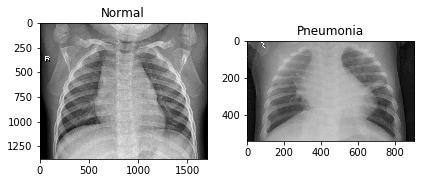

In [13]:
plt.subplot(1, 2, 1)
plt.imshow(normal_sample)
plt.title('Normal')

plt.subplot(1, 2, 2)
plt.imshow(pneumonia_sample)
plt.title('Pneumonia')

plt.tight_layout()
plt.show()

As you can see from above two images, image resolution for this dataset is not uniform. However, we will resize these images later so we don't need to worry about it now. If we look closer to both images, Normal X-Ray image have higher contrast and clear view in the center. Pneumonia image have lower contrast and more blurry view in the center. 

### Simple Exploratory Data Analysis

We will explore our dataset briefly and check how many images we have for each class. 





Normal       1349
Pneumonia    3883
Name: label, dtype: int64
Normal:  25.78 %
Pneumonia:  74.22 %


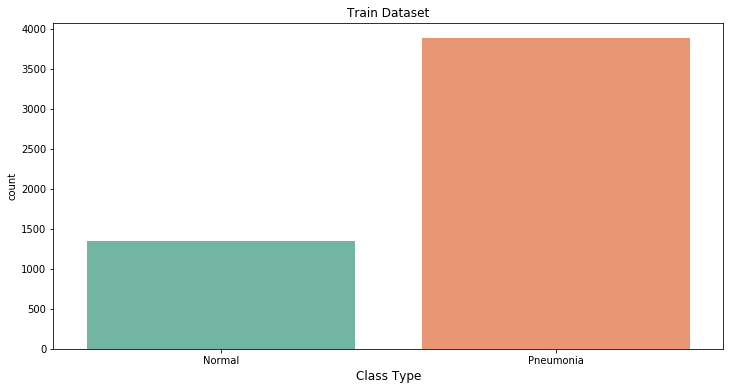

In [14]:
import seaborn as sns

train_label = train_df['label'].value_counts()
print(train_label.sort_index(ascending = True))

print('Normal: ',round((train_label[1]/train_label.sum())*100,2),'%')
print('Pneumonia: ',round((train_label[0]/train_label.sum())*100,2),'%')

plt.figure(figsize=(12,6))
sns.countplot(x='label', data=train_df, palette = 'Set2')
plt.xlabel('Class Type', fontsize=12)
plt.title('Train Dataset', fontsize=12)

plt.show()

Normal       234
Pneumonia    390
Name: label, dtype: int64
Normal:  37.5 %
Pneumonia:  62.5 %


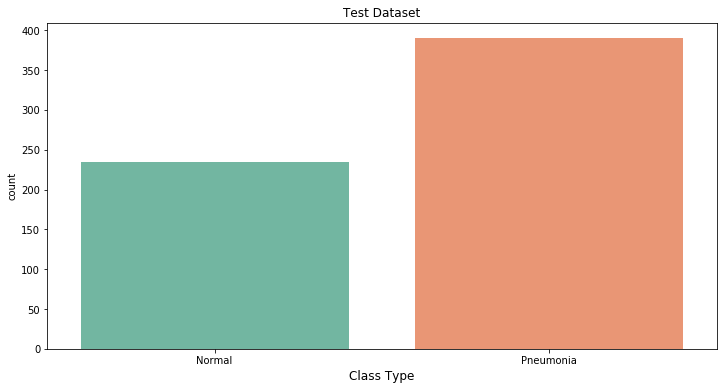

In [15]:
test_label = test_df['label'].value_counts()
print(test_label.sort_index(ascending = True))

print('Normal: ',round((test_label[1]/test_label.sum())*100,2),'%')
print('Pneumonia: ',round((test_label[0]/test_label.sum())*100,2),'%')

plt.figure(figsize=(12,6))
sns.countplot(x='label', data=test_df, palette = 'Set2')
plt.xlabel('Class Type', fontsize=12)
plt.title('Test Dataset', fontsize=12)

plt.show()

Both training and testing dataset are imbalance. An immbanalced dataset may increase the bias of our model. Also, it will influence the accuracy score as well. For example, our training dataset contains about 75% of Pneumonia images, and our test dataset contains about 63% of Pneumonia images, then our training accuracy and validation accuracy will return 75% and 63% even our model just classify all images as Pneumonia cases. Therefore, I will add an class weight to our model. In addition, I will evaluate the precision/recall scores, confusion matrix, and ROC curve of the model. 

### Class weight

In [0]:
# Create class weight for our model
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_df['label']),
                                                 train_df['label'])

## Data Augmentation and Pre-processing
Since we already have the directories of train and test datasets, and processing the images from a dataframe to Keras require intensive computing power, I decided to input the datasets from directories in batches. Data Augmentation will also happened at the same time for the training dataset. Data Augmentation is helpful here because we have a imbalance dataset, and sometimes X-Ray images may not always perfectly line up in all cases. 

In [17]:
# Define data generator parameter and data augmentation happened here
train_datagen=ImageDataGenerator(horizontal_flip = True,
                                 rotation_range = 0.1,
                                 width_shift_range = 0.1,
                                 zoom_range = 0.1)

# Create regular training data
# Also shuffle the training dataset here so we don't have all Normal class
# at the beginning and then Pneumonia class
train_data = train_datagen.flow_from_directory(train_dir,
                                               classes = ['NORMAL','PNEUMONIA'],
                                               class_mode="categorical",
                                               target_size=(256,256),
#                                               color_mode = 'rgb',
                                               shuffle=True,
                                               seed=4)

Found 5232 images belonging to 2 classes.


In [18]:
#Create testing data
test_datagen=ImageDataGenerator()
test_data = test_datagen.flow_from_directory(test_dir,
                                             classes = ['NORMAL','PNEUMONIA'],
                                             class_mode="categorical",
                                             target_size=(256,256),
                                             shuffle=False)

Found 624 images belonging to 2 classes.


### Check the first batch of train image

In [0]:
# Retrieve one bacth of data
x,y = train_data.next()

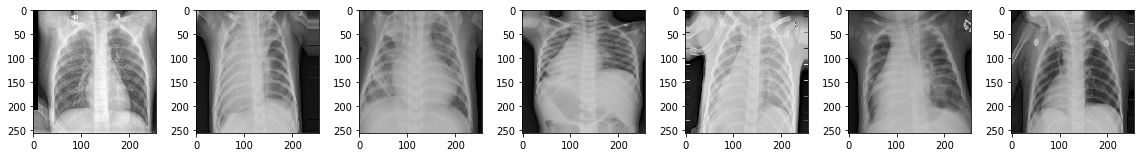

In [20]:
# Check if our data augmentation is working or not
plt.figure(figsize=(16,60))

for i in range(0,7):
    plt.subplot(1, 7, i+1)
    plt.imshow(x[i].astype(int))
    plt.tight_layout()
    

## Build the Model

One model will be built here, but this model will fit into two different training dataset. The original dataset will be added a class weight. The balanced dataset will not add class weight since two classes are balaned already. 

In [21]:
# Start Building the model
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',padding='same',
                 input_shape = train_data.image_shape))
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

W0710 22:51:19.245700 139640939304832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 22:51:19.327993 139640939304832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0710 22:51:19.531557 139640939304832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0710 22:51:19.638140 139640939304832 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instr

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
__________

In [23]:
# Compile our model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

W0710 22:51:19.880916 139640939304832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
# Set bacth size
batch_size = 64
# Define steps per epoch
steps_per_epoch = np.ceil(len(train_df) / batch_size)

# Define checkpoint, learning rate reduce criterias
# Monitor validation loss here because I don't want my model to overfit too much
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint, EarlyStopping

lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              epsilon=0.001,
                              patience=1,
                              verbose=1)

filepath="checkpoint.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

In [25]:
# Fit model with original dataset with class weight

history = model.fit_generator(epochs=18,
                              validation_data=test_data,
                              generator=train_data,
                              validation_steps=20,
                              steps_per_epoch=20,
                              class_weight=class_weights,
                              callbacks=[checkpoint],
                              shuffle=False,
                              verbose=2)

# After tuning the parameters manually, I found out that steps per epoch
# and validation steps = 20 return better model performance. 
# However, Keras documents recommend that steps = sample size / batch size. 
# Please use based on your own model performance. 

W0710 22:51:20.048310 139640939304832 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/18
 - 26s - loss: 1.0846 - acc: 0.7875 - val_loss: 1.2159 - val_acc: 0.7083

Epoch 00001: val_loss improved from inf to 1.21594, saving model to checkpoint.hdf5
Epoch 2/18
 - 19s - loss: 0.2937 - acc: 0.8813 - val_loss: 0.5765 - val_acc: 0.8574

Epoch 00002: val_loss improved from 1.21594 to 0.57647, saving model to checkpoint.hdf5
Epoch 3/18
 - 20s - loss: 0.2395 - acc: 0.8828 - val_loss: 0.7400 - val_acc: 0.8285

Epoch 00003: val_loss did not improve from 0.57647
Epoch 4/18
 - 20s - loss: 0.3096 - acc: 0.8938 - val_loss: 0.5835 - val_acc: 0.8397

Epoch 00004: val_loss did not improve from 0.57647
Epoch 5/18
 - 20s - loss: 0.2357 - acc: 0.9172 - val_loss: 0.6918 - val_acc: 0.8157

Epoch 00005: val_loss did not improve from 0.57647
Epoch 6/18
 - 20s - loss: 0.2951 - acc: 0.8844 - val_loss: 0.3874 - val_acc: 0.8622

Epoch 00006: val_loss improved from 0.57647 to 0.38745, saving model to checkpoint.hdf5
Epoch 7/18
 - 20s - loss: 0.2240 - acc: 0.9109 - val_loss: 0.6582 - val_acc: 

## Evaluate the Model

The model will be evaluated in multiple ways, including accuracy/validation accuracy, precision/recall score, confusion matrix, and ROC curve. 

### Accurcy/Loss Curve

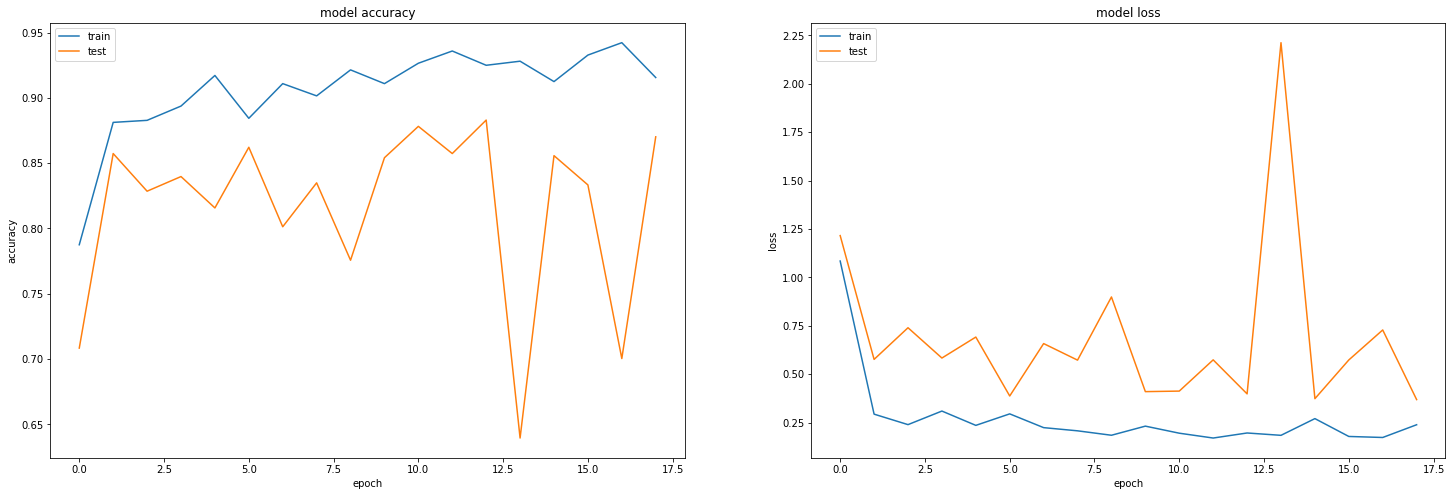

In [26]:
# Original Dataset with class weight
plt.figure(figsize=(25,8))

plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Precision Score/Recall Score
Since we have an imbalanced dataset, we will need to evaluate our model with precision score and recall score. Since this is a model for detecting if an X-Ray image indicate the patient have Pneumonia or not, we would need to be very careful about False Positive, which means a patient diagnosis as Normal, but have Pneumonia. Therefore, the model should be minimize number of False Positive, which means we should maximize our precision score. 


In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [28]:
#Get predictions from model

prediction = model.predict_generator(test_data,
                                     steps = 20,
                                     verbose = 1)

y_predict = np.argmax(prediction, axis=1)

# Get y_true from our datagenerator
y_true = test_data.classes

20/20 [==============================] - 7s 353ms/step


In [29]:
# Calculate precision and recall score

original_ps = precision_score(y_true,y_predict)
original_rs = recall_score(y_true, y_predict)
print('Original Dataset with class weight') 
print('Precision Score:', original_ps)
print('Recall Score:', original_rs)

Original Dataset with class weight
Precision Score: 0.8154613466334164
Recall Score: 0.8384615384615385


### Confusion Matrix
A confusion matrix can provide a direct way of how the model perform when predicting different classes. 

In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

cf_test = confusion_matrix(y_true, y_predict)

[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Pneumonia')]

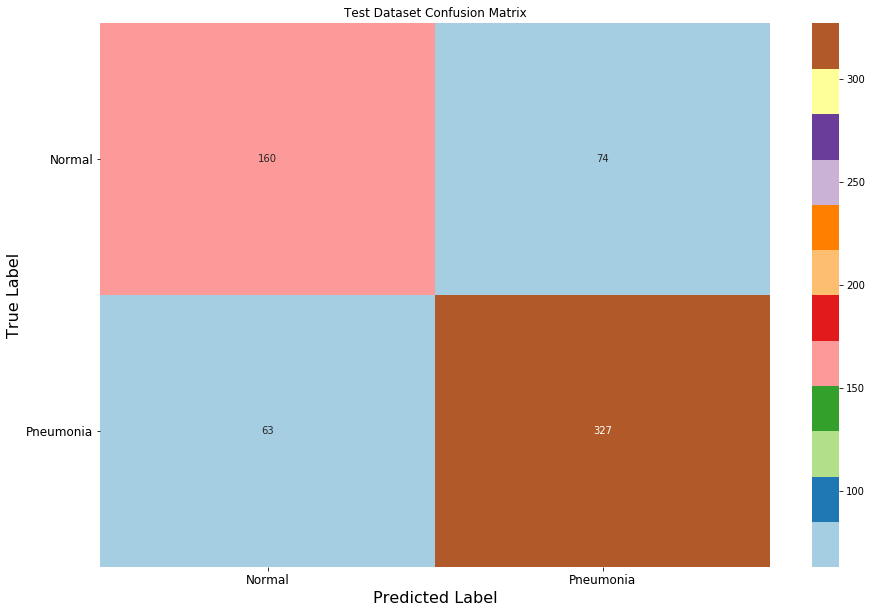

In [31]:
# Plot the confusion matrix
plt.figure(figsize = (15,10))

ax = sns.heatmap(cf_test,annot=True,fmt='d',cmap='Paired' )
plt.title("Test Dataset Confusion Matrix",
                   fontsize=12)
ax.set_xlabel("Predicted Label",fontsize=16)
ax.set_ylabel("True Label",fontsize=16)
ax.set_xticklabels(['Normal', 'Pneumonia'], fontsize=12, rotation=0)
ax.set_yticklabels(['Normal', 'Pneumonia'], fontsize=12, rotation=360)

### ROC Curve
A ROC curve tells us how well our model when distingushing between classes. A ROC curve plotted with True Positive Rate vs. False Positive Rate. If our model performs well, we will have a model with high TPR and curve above the 50% diagonal line. If our model performs poorly, then the curve will be below the 50% diagonal line. 

In [0]:
# ROC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

original_fpr, original_tpr, original_thresold = roc_curve(np.array(y_true),
                                                          prediction[:, 1],
                                                          pos_label=None)

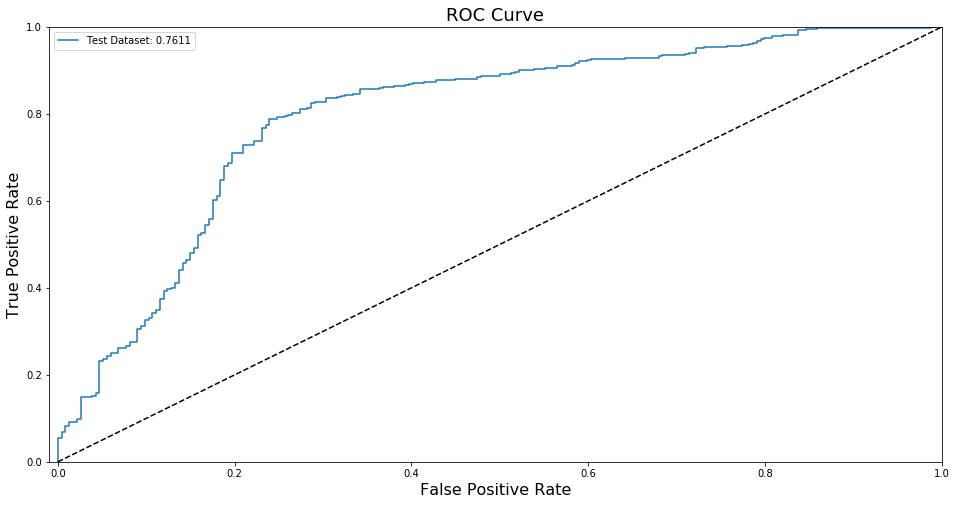

In [33]:
plt.figure(figsize=(16,8))
plt.title('ROC Curve', fontsize=18)
plt.plot(original_fpr, original_tpr, label='Test Dataset: {:.4f}'.format(
    roc_auc_score(y_true, y_predict)))
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend()
plt.show()

## What went wrong?
At the end, we also want to find out how many predictions are incorrect, and number of wrong predicions for each class. Afterward, we can re-train and fine tune our model purposely to have better prediction. 

In [34]:
# Make a copy of test_df
eval_df = test_df.copy()

# Changed label from str to 0 and 1. 
eval_df['label'].replace('Normal',0,inplace=True)
eval_df['label'].replace('Pneumonia',1,inplace=True)

eval_df['label'].unique()

array([0, 1])

In [0]:
# Before compare true value with prediction, we need to make sure label is 
# exactly the same as our y_true
check_true = []

for i in range(0, len(eval_df)):
    if eval_df['label'][i] == y_true[i]:
        check_true.append(0)
    else:
        check_true.append(1)

In [36]:
# If our label is exactly the same as y_true, this code will return False.
1 in check_true

False

In [0]:
# Make a new column that specify correct and wrong prediction
comparison = []

for i in range(0, len(eval_df)):
    if eval_df['label'][i] == y_predict[i]:
        comparison.append('Correct')
    else:
        comparison.append('Wrong')
        
eval_df['comparison'] = comparison

In [38]:
# Check the number of wong predictions with our confusion matrix number.
eval_df[eval_df['comparison'] == 'Wrong'].count()

image         137
label         137
comparison    137
dtype: int64

In [39]:
# Create a new dataframe to store all wrong predictions. 
wrong_df = pd.DataFrame()

wrong_df = eval_df[eval_df['comparison'] == 'Wrong']

wrong_df.shape

(137, 3)

In [0]:
# Reset the index of the wrong prediction dataframe
wrong_df.reset_index(drop=True, inplace=True)

In [0]:
# Find out the class of each wrong prediction
text_label = []

for i in range(0, len(wrong_df)):
    if 'bacteria' in str(wrong_df['image'][i]):
        text_label.append('Bacterial')
    elif 'virus' in str(wrong_df['image'][i]):
        text_label.append('Viral')
    else:
        text_label.append('Normal')
        
# Input the text_label as a column
wrong_df['text_label'] = text_label

Bacterial    42
Normal       74
Viral        21
Name: text_label, dtype: int64


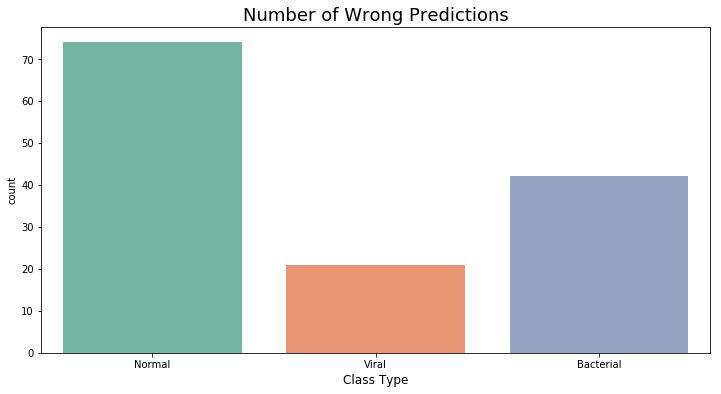

In [42]:
# Print the value of each wrong prediction class and its number
print(wrong_df['text_label'].value_counts().sort_index(ascending = True))

plt.figure(figsize=(12,6))
plt.title('Number of Wrong Predictions', fontsize=18)
sns.countplot(x='text_label', data=wrong_df, palette = 'Set2')
plt.xlabel('Class Type', fontsize=12)

plt.show()

At the end, we can see that for false positive predictions, there are more bacterial Pneumonia are failed to predict compare to Virual Pneumonia. Therefore, we could try to work with professionals to check what are key characteristics to disgush Bacterial Pneumonia and Virual Pneumonia, and then try to reduce the number of wrong predictions for baterial Pneumonia first. However, our ultimate goal is to create a model that correct predict each case. 